**In this script, the calculated clusters will be qualitatively interpreted to gain an understanding of each of the types of actors**

# Imports and Data Loading

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import networkx as nx

In [ ]:
full_data = pd.read_csv('../results/author_full_features_and_clusters.csv')

In [ ]:
# rename clusters
full_data['cluster'] = full_data['cluster'].replace({0: 'Cluster 1', 3: 'Cluster 2', 4: 'Cluster 3', 5: 'Cluster 4'})
full_data.drop(columns=['cluster_1_prob', 'cluster_2_prob'], inplace=True)
full_data.rename(columns={'cluster_0_prob': 'Cluster 1', 'cluster_3_prob': 'Cluster 2', 'cluster_4_prob': 'Cluster 3', 'cluster_5_prob': 'Cluster 4'}, inplace=True)

In [ ]:
features = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

# Visualizing Node Embedidngs

In [ ]:
# load embeddings from npy files
embeddings = np.load('../results/author_full_embeddings.npy')

In [ ]:
# fit tsne
tsne = TSNE(n_components=2, random_state=42)

tsne_4 = tsne.fit_transform(embeddings)

In [ ]:
# plot t-SNE embeddings
plt.figure(figsize=(25, 15))
scatter = plt.scatter(tsne_4[:,0], tsne_4[:,1], c=full_data['cluster'].astype('category').cat.codes, cmap='Accent', s=100)
plt.title('t-SNE Visualization of Node Embeddings Colored by Cluster Assignment')

# legend
handles, labels = scatter.legend_elements(prop="colors")
unique_labels = full_data['cluster'].unique()
legend_labels = [f'{label}' for label in unique_labels]
legend_labels.sort()
plt.legend(handles, legend_labels, markerscale=2)

# adjust font size
plt.rc('legend', fontsize=24)
plt.rc('axes', titlesize=26)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

# legend title
plt.gca().get_legend().set_title('')

# make points in legend bigger
plt.setp(plt.gca().get_legend().get_texts(), fontsize='24')

plt.show()

    - Well separated classes
    - pink class biggest and more dispersed
    - yellow class small and compact; probably some similarities to dark blue class

# Distribution of Linguistic Features in Clusters

In [ ]:
# get mean of eaxh feature oe each cluster
means = features.groupby('cluster').mean()
means

    - soome features show (small differences), others don't
    - needs to be tested if it is statistically significant

In [ ]:
Counter(full_data['cluster'])

In [ ]:
# add number of authors in each cluster to df
cluster_counts = full_data['cluster'].value_counts()
cluster_counts = cluster_counts.reset_index()
cluster_counts.columns = ['cluster', 'count']
means = means.merge(cluster_counts, on='cluster', how='left')

In [ ]:
means.to_excel('../results/feature_means.xlsx', index=True)

# Correlation

## Testing Assumptions

## Cluster 1

In [ ]:
# testing linear relatio between features and clusters
for x in features.columns[:-1]:
    sns.scatterplot(x=full_data[x], y=full_data['Cluster 1'])
    plt.title(f'Scatter Plot of {x} and Cluster 1')
    plt.xlabel(f'{x}')
    plt.ylabel('Cluster 1')
    plt.show()

In [ ]:
corr_1 = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'cluster', 'Cluster 2', 'Cluster 3', 'Cluster 4']).corr(method='spearman')
corr_1['Cluster 1'].sort_values(ascending=False)

In [ ]:
# highly correlated features with Cluster 1
corr_1['Cluster 1'][abs(corr_1['Cluster 1']) > 0.7]

## Cluster 2

In [ ]:
corr_2 = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'cluster', 'Cluster 1', 'Cluster 3', 'Cluster 4']).corr(method='spearman')
corr_2['Cluster 2'].sort_values(ascending=False)

In [ ]:
# highly correlated features with Cluster 2
corr_2['Cluster 2'][abs(corr_2['Cluster 2']) > 0.7]

## Cluster 3

In [ ]:
corr_3 = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'cluster', 'Cluster 1', 'Cluster 2', 'Cluster 4']).corr(method='spearman')
corr_3['Cluster 3'].sort_values(ascending=False)

In [ ]:
# highly correlated features with Cluster 3
corr_3['Cluster 3'][abs(corr_3['Cluster 3']) > 0.7]

## Cluster 4

In [ ]:
corr_4 = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'cluster', 'Cluster 1', 'Cluster 2', 'Cluster 3']).corr(method='spearman')
corr_4['Cluster 4'].sort_values(ascending=False)

In [ ]:
# highly correlated features with Cluster 4
corr_4['Cluster 4'][abs(corr_4['Cluster 4']) > 0.7]

    No correlations for any of the features

# Multinomial Logistic Regression

In [ ]:
features.columns

In [ ]:
# create train test split
X = features.drop(columns=['cluster'])
y = features['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [ ]:
# impute missing values & scale data
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_test = imputer.fit_transform(X_test)
X_test = scaler.fit_transform(X_test)

In [ ]:
# combine over and under sampling to handle class imbalance
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=5000, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

In [ ]:
# predictions
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)

In [ ]:
# evaluate model
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 Score:',f1_score(y_test, predictions, average='weighted'))
print('\nClassification Report:\n', classification_report(y_test, predictions))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, predictions))

    MLR cannot handle class imbalance well

# Network Metrics

In [2]:
adj = np.load('../results/author_full_adj.npy')

In [3]:
G = nx.from_numpy_array(adj)

In [5]:
# get basic information about graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
degrees = dict(G.degree())
avg_degree = int(np.mean(list(degrees.values())))
min_degree = np.min(list(degrees.values()))
max_degree = np.max(list(degrees.values()))

In [6]:
print('Total Number of Nodes:', num_nodes)
print('Total Number of Edges:', num_edges)
print('Average Degree:', avg_degree)
print('Minimum Degree:', min_degree)
print('Maximum Degree:', max_degree)

Total Number of Nodes: 16885
Total Number of Edges: 60965422
Average Degree: 7221
Minimum Degree: 0
Maximum Degree: 16821


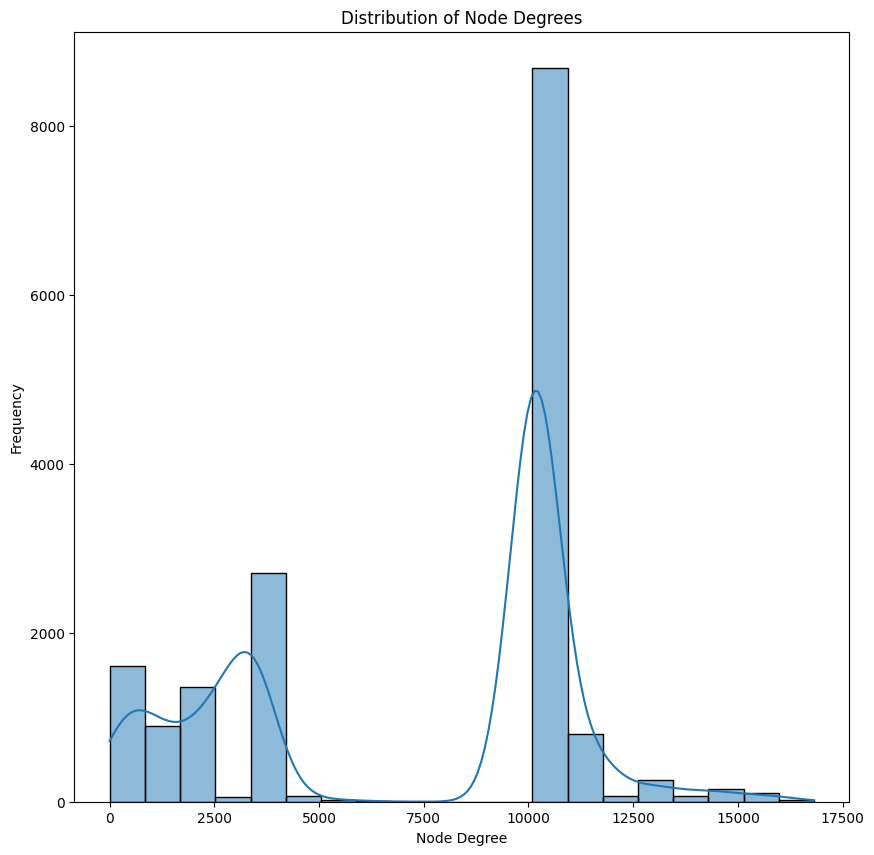

In [11]:
# distribution of degrees
plt.figure(figsize=(10, 10))
sns.histplot(list(degrees.values()), bins=20, kde=True)
plt.title('Distribution of Node Degrees')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.show()